# Predicting Deutsche Bahn Train Delays  
## A Reproducible Baseline for Supervised Regression

**Objective:** Build a supervised regression model to predict train arrival delays (in minutes) for Deutsche Bahn trains using statistical learning methods.

**Target Variable:** `arrival_delay_m` - continuous variable representing delay in minutes

---

## 1. Environment Setup and Imports

### Google Colab Setup

In [1]:
# Check if running in Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab")

    # Install required packages
    %pip install pandas numpy matplotlib seaborn scikit-learn scipy kagglehub mlxtend psutil -q

    # Mount Google Drive (optional - for saving results)
    from google.colab import drive
    drive.mount('/content/drive')

    # Set memory-efficient pandas options
    import pandas as pd
    pd.options.mode.chained_assignment = None
    pd.options.display.max_columns = 50

else:
    print("Running locally")

Running in Google Colab
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.6 MB/s eta 0:00:00
Mounted at /content/drive


### Local Setup (Anaconda/Miniconda)

For local installation, follow these steps in your terminal:

```bash
# 1. Install Anaconda or Miniconda
# Download from: https://www.anaconda.com/download or https://docs.conda.io/en/latest/miniconda.html

# 2. Create a new conda environment
conda create -n ml-db-delays python=3.9 -y

# 3. Activate the environment
conda activate ml-db-delays

# 4. Install required packages
conda install -c conda-forge pandas numpy matplotlib seaborn scikit-learn scipy jupyter notebook ipykernel -y

# 5. Install additional packages via pip
pip install kagglehub

# 6. Add kernel to Jupyter
python -m ipykernel install --user --name ml-db-delays --display-name "ML DB Delays"

# 7. Launch Jupyter Notebook
jupyter notebook

# 8. Select the "ML DB Delays" kernel when creating/opening the notebook
```

### Mathematical Foundation (ISLR Chapter 2.1)

We model the relationship between predictors and response as:

$$Y = f(X) + \epsilon$$

where:
- $Y$ is the response variable (arrival delay in minutes)
- $X = (X_1, X_2, ..., X_p)$ represents our $p$ predictors
- $f$ is the unknown systematic function we aim to estimate
- $\epsilon$ is the irreducible error with $E(\epsilon) = 0$

Our goal is to estimate $\hat{f}$ such that $\hat{Y} = \hat{f}(X)$ minimizes the expected prediction error:

$$E[(Y - \hat{Y})^2] = E[(f(X) + \epsilon - \hat{f}(X))^2]$$

### Import Required Libraries

In [2]:
# Standard library imports
import os
import sys
import gc
import warnings
from datetime import datetime
import psutil

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV,
    KFold, learning_curve, validation_curve
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest, f_regression

# Feature selection
from mlxtend.feature_selection import SequentialFeatureSelector

# Statistical analysis
from scipy import stats

# Kaggle data loading
import kagglehub

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)

# Memory-efficient pandas settings
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 100  # Reduce DPI for memory efficiency

# Memory monitoring function
def check_memory():
    """Monitor memory usage"""
    if 'psutil' in sys.modules:
        process = psutil.Process(os.getpid())
        mem_info = process.memory_info()
        return f"Memory Usage: {mem_info.rss / 1024 / 1024 / 1024:.2f} GB"
    else:
        return "psutil not available - install with: pip install psutil"

print("All packages imported successfully!")
print(check_memory())

All packages imported successfully!
Memory Usage: 0.26 GB


---

## 2. Data Loading and Initial Inspection

### The Supervised Learning Workflow (Lecture Slides)

Following the supervised learning experiment steps:
1. **Training data** → **Preprocessing** → **Feature extraction** → **Feature selection** → **Training**
2. **Test data** → **Preprocessing** → **Selected feature extraction** → **Classifier** → **Classification result**


In [3]:
# Download dataset
print("Downloading Deutsche Bahn delays dataset...")
path = kagglehub.dataset_download("nokkyu/deutsche-bahn-db-delays")
print(f"Dataset downloaded to: {path}")

# Find the CSV file robustly
import glob

csv_files = glob.glob(os.path.join(path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV file found in {path}")
file_path = csv_files[0]
print(f"\nLoading data from: {file_path}")

# Load data with optimized settings
print("\nLoading dataset...")
df = pd.read_csv(file_path,
                 parse_dates=['arrival_plan', 'departure_plan', 'arrival_change', 'departure_change'],
                 low_memory=False)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
print(check_memory())

# For extremely large datasets, consider sampling
if len(df) > 2_000_000:  # If more than 2 million rows
    print(f"\nDataset has {len(df):,} rows. Sampling for manageable processing...")
    df = df.sample(n=min(1_000_000, len(df)), random_state=42)
    print(f"Working with {len(df):,} sampled rows")
    gc.collect()


100%|██████████| 103M/103M [00:00<00:00, 250MB/s] 

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/nokkyu/deutsche-bahn-db-delays/versions/3

Loading data from: /root/.cache/kagglehub/datasets/nokkyu/deutsche-bahn-db-delays/versions/3/DBtrainrides.csv

Loading dataset...
Dataset loaded successfully!
Shape: (2061357, 20)
Memory usage: 1700.75 MB
Memory Usage: 1.19 GB

Dataset has 2,061,357 rows. Sampling for manageable processing...
Working with 1,000,000 sampled rows


### Initial Data Quality Assessment

As stated in the slides: "The data quality should be good" and "Before doing classification/regression experiments, you should be familiar with the data."


In [4]:
# Basic information
print("\n" + "="*60)
print("Dataset Overview:")
print("="*60)
print(df.info())
print("\n" + "="*60)
print("\nFirst 5 rows:")
print(df.head())

# Target variable analysis
print("\n" + "="*60)
print("\nTarget Variable Analysis (arrival_delay_m):")
print(df['arrival_delay_m'].describe())

# Missing values
print("\n" + "="*60)
print("\nMissing Values:")
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
})
print(missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False))


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 880682 to 495737
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   ID                     1000000 non-null  object        
 1   line                   1000000 non-null  object        
 2   path                   897343 non-null   object        
 3   eva_nr                 1000000 non-null  int64         
 4   category               1000000 non-null  int64         
 5   station                1000000 non-null  object        
 6   state                  1000000 non-null  object        
 7   city                   1000000 non-null  object        
 8   zip                    1000000 non-null  int64         
 9   long                   1000000 non-null  float64       
 10  lat                    1000000 non-null  float64       
 11  arrival_plan           897343 non-null   datetime64[ns]
 12  departure_

---

## 3. Data Preprocessing

### 3.1 Remove Duplicates

First step in data cleaning: remove duplicate records to ensure data quality.

In [5]:
print("\n" + "="*80)
print("DUPLICATE REMOVAL")
print("="*80)

initial_rows = len(df)
df = df.drop_duplicates()
final_rows = len(df)

print(f"Rows before removing duplicates: {initial_rows:,}")
print(f"Rows after removing duplicates: {final_rows:,}")
print(f"Duplicates removed: {initial_rows - final_rows:,} ({(initial_rows - final_rows)/initial_rows*100:.2f}%)")


DUPLICATE REMOVAL
Rows before removing duplicates: 1,000,000
Rows after removing duplicates: 998,409
Duplicates removed: 1,591 (0.16%)


### 3.2 Missing Value Analysis and Treatment

Following best practices: analyze missing patterns before deciding on treatment strategy.

Following the lecture approach 🫡: "Look at all your data (if possible). Do proper visualizations before the experiments to detect problems early on."


MISSING VALUE ANALYSIS


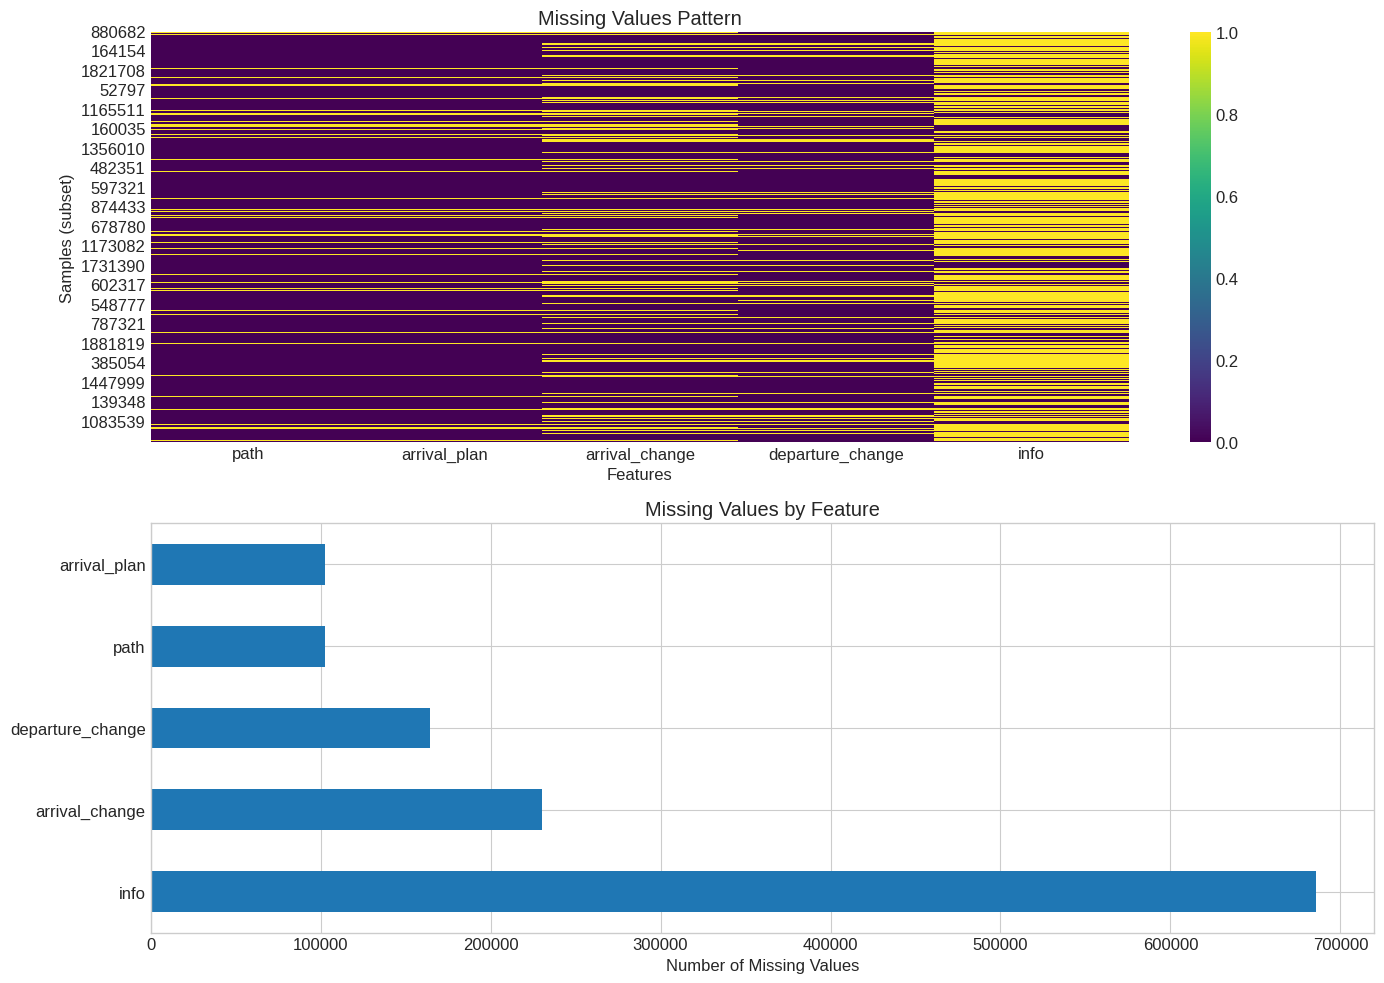


Missing Value Treatment:
Removed 0 rows with missing target values
Removed additional rows with missing critical features
Final dataset size: 998,409 rows


In [6]:
print("\n" + "="*80)
print("MISSING VALUE ANALYSIS")
print("="*80)

# Analyze missing patterns
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Missing values heatmap
missing_cols = df.columns[df.isnull().any()].tolist()
if missing_cols:
    sns.heatmap(df[missing_cols].isnull(), cbar=True, ax=axes[0], cmap='viridis')
    axes[0].set_title('Missing Values Pattern')
    axes[0].set_xlabel('Features')
    axes[0].set_ylabel('Samples (subset)')

# Missing values by column
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
missing_data.plot(kind='barh', ax=axes[1])
axes[1].set_xlabel('Number of Missing Values')
axes[1].set_title('Missing Values by Feature')

plt.tight_layout()
plt.show()

# Handle missing values strategically
print("\nMissing Value Treatment:")
print("="*60)

# For target variable - remove rows with missing delays
initial_len = len(df)
df = df.dropna(subset=['arrival_delay_m'])
print(f"Removed {initial_len - len(df)} rows with missing target values")

# For critical features - remove rows
critical_features = ['eva_nr', 'category', 'departure_delay_m']
df = df.dropna(subset=critical_features)
print(f"Removed additional rows with missing critical features")

# Fill remaining missing values
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

for col in numerical_cols:
    if col not in ['arrival_delay_m']:
        df[col] = df[col].fillna(df[col].median())

print(f"Final dataset size: {len(df):,} rows")

### 3.3 Feature Engineering

Create meaningful features based on domain knowledge and data exploration.

In [ ]:
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Convert datetime to epoch (numeric value) for model training
df['departure_epoch'] = pd.to_datetime(df['departure_plan']).astype(int) / 10**9
df['arrival_epoch'] = pd.to_datetime(df['arrival_plan']).astype(int) / 10**9


# Extract temporal features
df['hour'] = pd.to_datetime(df['departure_plan']).dt.hour
df['day_of_week'] = pd.to_datetime(df['departure_plan']).dt.dayofweek
df['month'] = pd.to_datetime(df['departure_plan']).dt.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)

# Station-based aggregated features
print("Creating station-based features...")
station_delay_stats = df.groupby('station')['arrival_delay_m'].agg(['mean', 'std', 'count']).reset_index()
station_delay_stats.columns = ['station', 'station_avg_delay', 'station_std_delay', 'station_traffic']
df = df.merge(station_delay_stats, on='station', how='left')

# Category-based aggregated features
print("Creating category-based features...")
category_delay_stats = df.groupby('category')['arrival_delay_m'].agg(['mean', 'std']).reset_index()
category_delay_stats.columns = ['category', 'category_avg_delay', 'category_std_delay']
df = df.merge(category_delay_stats, on='category', how='left')

print("\nNew features created:")
print("- Temporal: hour, day_of_week, month, is_weekend, is_rush_hour")
print("- Station-based: station_avg_delay, station_std_delay, station_traffic")
print("- Category-based: category_avg_delay, category_std_delay")


FEATURE ENGINEERING
Creating station-based features...
Creating category-based features...

New features created:
- Temporal: hour, day_of_week, month, is_weekend, is_rush_hour
- Station-based: station_avg_delay, station_std_delay, station_traffic
- Category-based: category_avg_delay, category_std_delay


### 3.4 Initial Outlier Analysis (Pre-modeling)

Following lecture slides on "Outliers, cross validation, resampling":

**IQR Method**: Values outside $[Q_1 - 1.5 \times IQR, Q_3 + 1.5 \times IQR]$ are potential outliers


Initial Outlier Analysis:
Q1 (25th percentile): 0.00 minutes
Q3 (75th percentile): 1.00 minutes
IQR: 1.00 minutes
Lower bound: -1.50 minutes
Upper bound: 2.50 minutes

Outliers detected: 130003 (13.02%)


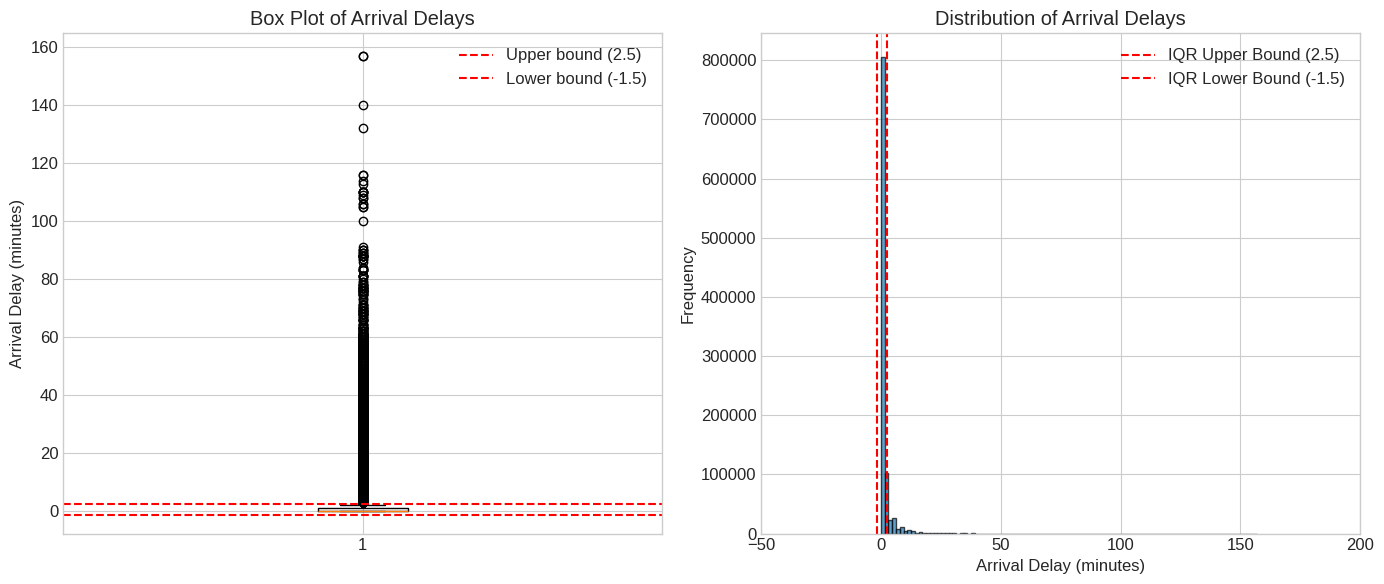

In [8]:
# Initial outlier analysis on target variable
Q1 = df['arrival_delay_m'].quantile(0.25)
Q3 = df['arrival_delay_m'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("\n" + "="*60)
print("Initial Outlier Analysis:")
print("="*60)
print(f"Q1 (25th percentile): {Q1:.2f} minutes")
print(f"Q3 (75th percentile): {Q3:.2f} minutes")
print(f"IQR: {IQR:.2f} minutes")
print(f"Lower bound: {lower_bound:.2f} minutes")
print(f"Upper bound: {upper_bound:.2f} minutes")

outliers = (df['arrival_delay_m'] < lower_bound) | (df['arrival_delay_m'] > upper_bound)
print(f"\nOutliers detected: {outliers.sum()} ({outliers.sum()/len(df)*100:.2f}%)")

# Visualize outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot
axes[0].boxplot(df['arrival_delay_m'].values, vert=True)
axes[0].set_ylabel('Arrival Delay (minutes)')
axes[0].set_title('Box Plot of Arrival Delays')
axes[0].axhline(y=upper_bound, color='r', linestyle='--', label=f'Upper bound ({upper_bound:.1f})')
axes[0].axhline(y=lower_bound, color='r', linestyle='--', label=f'Lower bound ({lower_bound:.1f})')
axes[0].legend()

# Histogram with outlier boundaries
axes[1].hist(df['arrival_delay_m'], bins=100, alpha=0.7, edgecolor='black')
axes[1].axvline(upper_bound, color='red', linestyle='--', label=f'IQR Upper Bound ({upper_bound:.1f})')
axes[1].axvline(lower_bound, color='red', linestyle='--', label=f'IQR Lower Bound ({lower_bound:.1f})')
axes[1].set_xlabel('Arrival Delay (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Arrival Delays')
axes[1].set_xlim(-50, 200)
axes[1].legend()

plt.tight_layout()
plt.show()

# Note: We'll handle outliers after fitting the base model using residual analysis

---

## 4. Exploratory Data Analysis

### 4.1 Target Variable Distribution


TARGET VARIABLE ANALYSIS


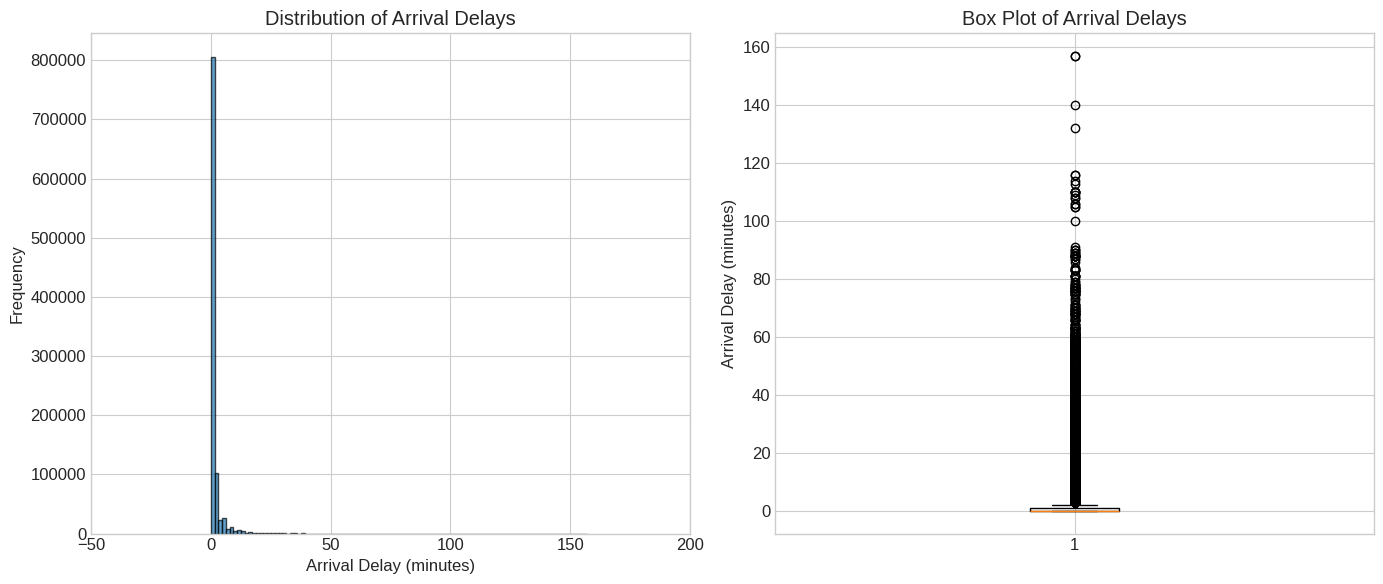


Target Variable Statistics:
count    998409.000000
mean          1.173958
std           3.409101
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         157.000000
Name: arrival_delay_m, dtype: float64


In [9]:
print("\n" + "="*80)
print("TARGET VARIABLE ANALYSIS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Distribution plot
axes[0].hist(df['arrival_delay_m'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Arrival Delay (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Arrival Delays')
axes[0].set_xlim(-50, 200)

# Box plot
axes[1].boxplot(df['arrival_delay_m'], vert=True)
axes[1].set_ylabel('Arrival Delay (minutes)')
axes[1].set_title('Box Plot of Arrival Delays')

plt.tight_layout()
plt.show()

# Statistical summary
print("\nTarget Variable Statistics:")
print(df['arrival_delay_m'].describe())

### 4.2 Feature Correlations

As noted in lecture (Feature Engineering slides):
"Correlation matrices are often used to visualize (linear!) dependency among features."

**Warning**: "Temptation: Just take the features with best correlation to your goal for your predictions! This is deeply wrong."


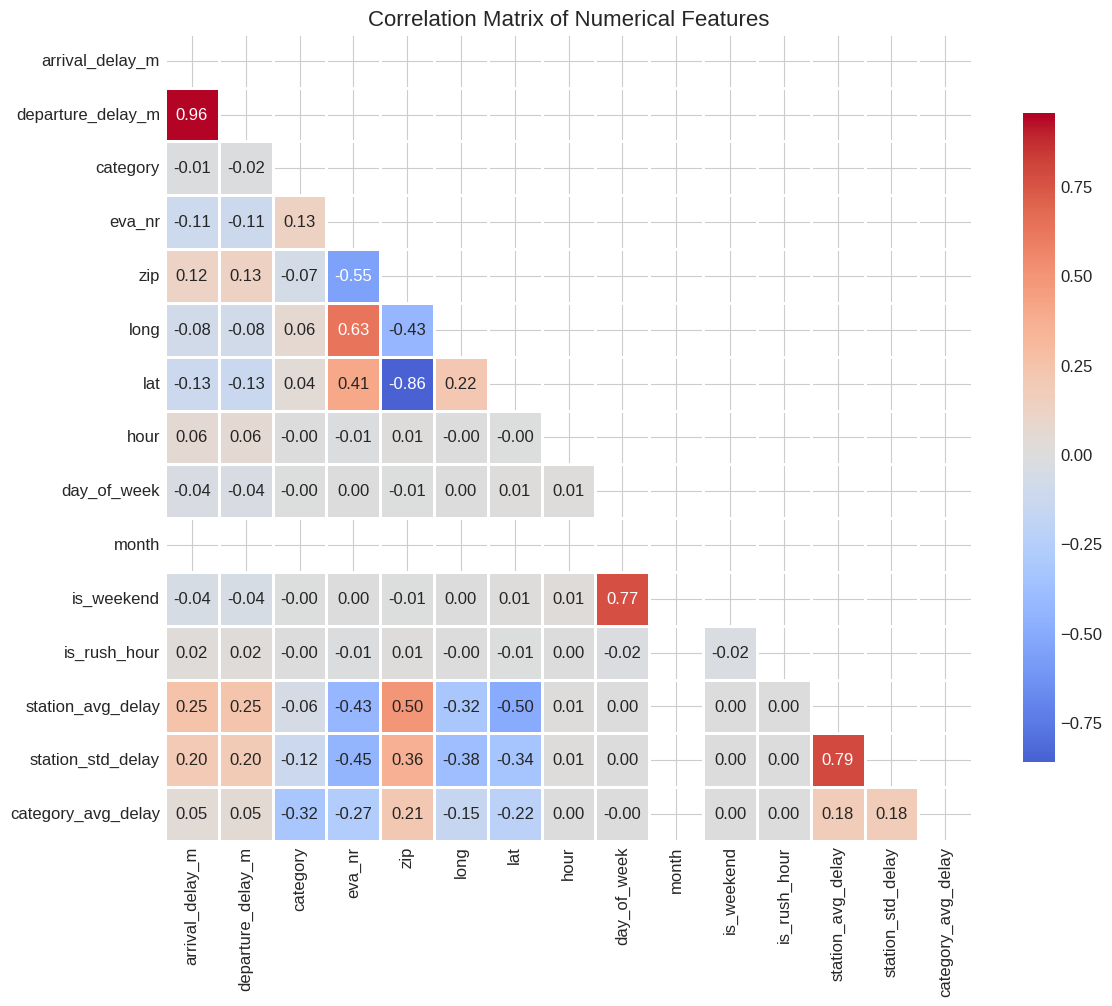


TOP CORRELATIONS WITH TARGET VARIABLE
departure_delay_m     0.955873
station_avg_delay     0.250893
station_std_delay     0.198049
zip                   0.124996
hour                  0.055199
category_avg_delay    0.045712
is_rush_hour          0.018231
category             -0.014436
day_of_week          -0.036046
is_weekend           -0.044936
Name: arrival_delay_m, dtype: float64


In [10]:
# Select numerical features for correlation analysis
numerical_features = ['arrival_delay_m', 'departure_delay_m', 'category', 'eva_nr',
                     'zip', 'long', 'lat', 'hour', 'day_of_week', 'month',
                     'is_weekend', 'is_rush_hour', 'station_avg_delay',
                     'station_std_delay', 'category_avg_delay']

# Calculate correlation matrix
corr_matrix = df[numerical_features].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

# Top correlations with target
print("\n" + "="*80)
print("TOP CORRELATIONS WITH TARGET VARIABLE")
print("="*80)
target_corr = corr_matrix['arrival_delay_m'].sort_values(ascending=False)
print(target_corr[1:11])  # Exclude self-correlation

### 4.3 Feature Relationships


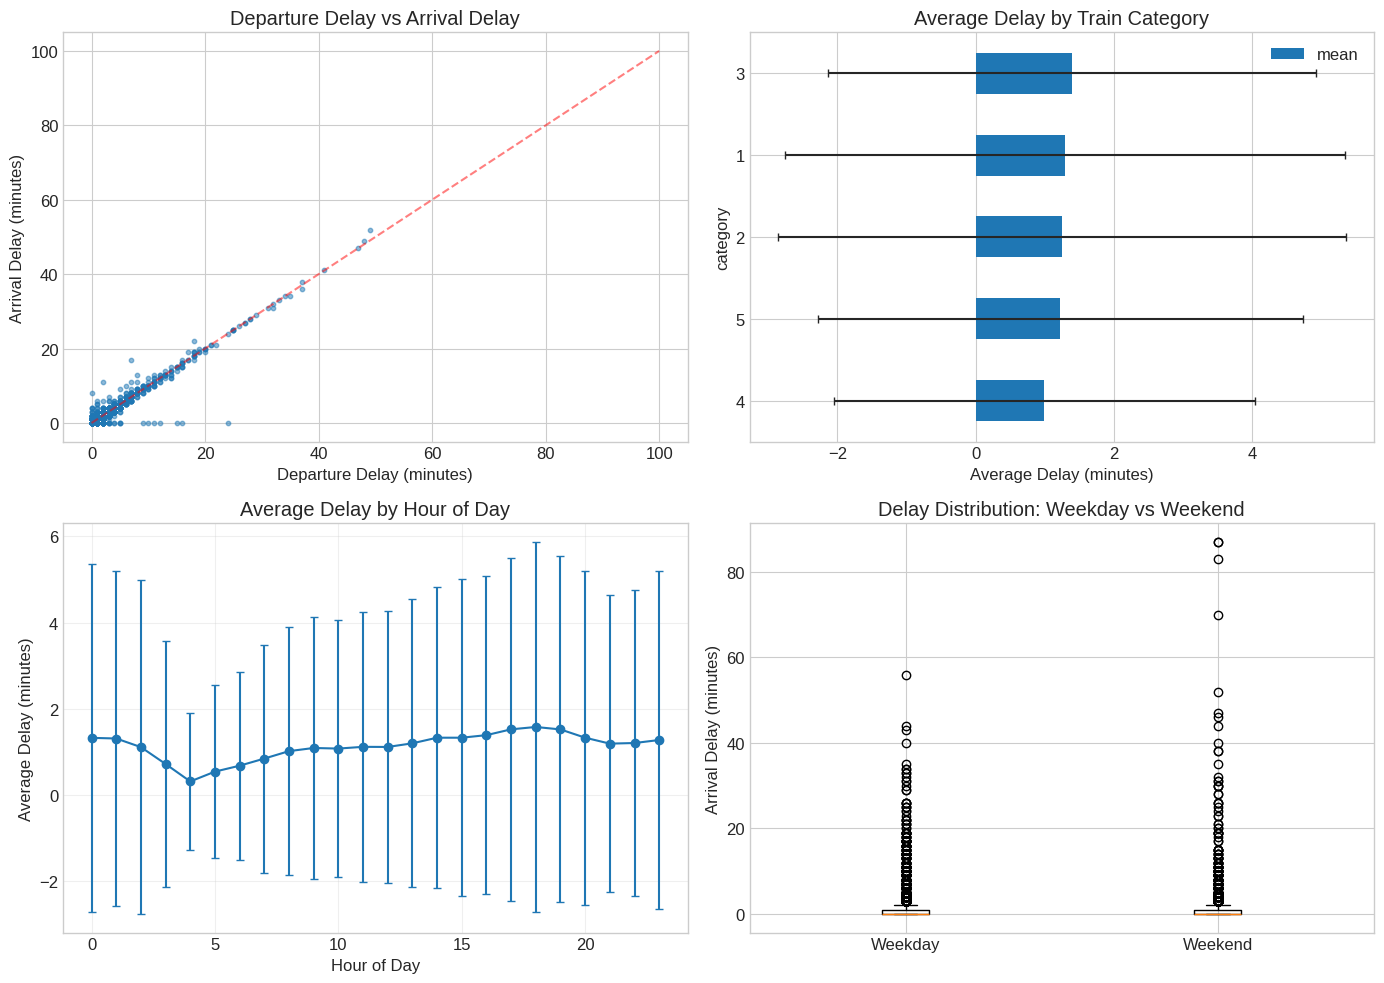

In [11]:
# Analyze key relationships
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Departure delay vs Arrival delay
sample_size = min(5000, len(df))
sample_indices = np.random.choice(df.index, sample_size, replace=False)
axes[0, 0].scatter(df.loc[sample_indices, 'departure_delay_m'],
                   df.loc[sample_indices, 'arrival_delay_m'],
                   alpha=0.5, s=10)
axes[0, 0].set_xlabel('Departure Delay (minutes)')
axes[0, 0].set_ylabel('Arrival Delay (minutes)')
axes[0, 0].set_title('Departure Delay vs Arrival Delay')
axes[0, 0].plot([0, 100], [0, 100], 'r--', alpha=0.5)

# 2. Average delay by category
category_delays = df.groupby('category')['arrival_delay_m'].agg(['mean', 'std'])
category_delays.sort_values('mean').plot(y='mean', kind='barh', ax=axes[0, 1],
                                        xerr='std', capsize=3)
axes[0, 1].set_xlabel('Average Delay (minutes)')
axes[0, 1].set_title('Average Delay by Train Category')

# 3. Hourly pattern
hourly_pattern = df.groupby('hour')['arrival_delay_m'].agg(['mean', 'std'])
axes[1, 0].errorbar(hourly_pattern.index, hourly_pattern['mean'],
                    yerr=hourly_pattern['std'], marker='o', capsize=3)
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Average Delay (minutes)')
axes[1, 0].set_title('Average Delay by Hour of Day')
axes[1, 0].grid(True, alpha=0.3)

# 4. Weekend effect
weekend_comparison = df.groupby('is_weekend')['arrival_delay_m'].apply(list)
axes[1, 1].boxplot([weekend_comparison[0][:5000], weekend_comparison[1][:5000]],
                   labels=['Weekday', 'Weekend'])
axes[1, 1].set_ylabel('Arrival Delay (minutes)')
axes[1, 1].set_title('Delay Distribution: Weekday vs Weekend')

plt.tight_layout()
plt.show()

---

## 5. Data Splitting



### Train-Validation-Test Split (60-20-20)

Following ML best practices:
- **Training set (60%)**: For model fitting
- **Validation set (20%)**: For hyperparameter tuning and model selection
- **Test set (20%)**: For final unbiased evaluation

In [ ]:
print("\n" + "="*80)
print("DATA SPLITTING")
print("="*80)

# Define features and target
feature_columns = [
    # Numerical features
    'eva_nr', 'category', 'zip', 'long', 'lat', 'departure_delay_m',
    'departure_epoch', 'arrival_epoch',
    'hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour',
    'station_avg_delay', 'station_std_delay', 'station_traffic',
    'category_avg_delay', 'category_std_delay',
    # Categorical features
    'station', 'state', 'line'
]

X = df[feature_columns].copy()
y = df['arrival_delay_m'].copy()

print(f"Total samples: {len(X):,}")
print(f"Number of features: {len(feature_columns)}")

# First split: separate test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Second split: separate train (60%) and validation (20%) from remaining 80%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, shuffle=True  # 0.25 * 0.8 = 0.2
)

print(f"\nDataset splits:")
print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify target distribution is similar across splits
print(f"\nTarget variable statistics by split:")
print(f"Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Val   - Mean: {y_val.mean():.2f}, Std: {y_val.std():.2f}")
print(f"Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")


DATA SPLITTING
Total samples: 998,409
Number of features: 19

Dataset splits:
Training set: 599,045 samples (60.0%)
Validation set: 199,682 samples (20.0%)
Test set: 199,682 samples (20.0%)

Target variable statistics by split:
Train - Mean: 1.18, Std: 3.43
Val   - Mean: 1.17, Std: 3.38
Test  - Mean: 1.16, Std: 3.37


---

## 6. Feature Preprocessing Pipeline

### StandardScaler and OneHotEncoder in Pipeline

From ISLR Section 4.7.4: "A good way to handle this problem is to standardize the data so that all variables are given a mean of zero and a standard deviation of one."

**Important**: Apply preprocessing only on training data to avoid data leakage!

In [13]:
print("\n" + "="*80)
print("PREPROCESSING PIPELINE SETUP")
print("="*80)

# Identify numerical and categorical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Create preprocessing pipeline
# StandardScaler: transforms features to have mean=0 and std=1
# OneHotEncoder: creates binary features for each category
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore'),
         categorical_features)
    ],
    remainder='drop'  # Drop any other columns
)

# IMPORTANT: Fit preprocessor on training data ONLY
print("\nFitting preprocessor on training data...")
preprocessor.fit(X_train)

# Get feature names after preprocessing
feature_names = (
    numerical_features +
    [f"{cat}_{val}" for cat, vals in
     zip(categorical_features, preprocessor.named_transformers_['cat'].categories_)
     for val in vals[1:]]  # drop='first' removes first category
)

print(f"\nTotal features after preprocessing: {len(feature_names)}")
print("Preprocessing pipeline created and fitted on training data only!")


PREPROCESSING PIPELINE SETUP
Numerical features (13): ['eva_nr', 'category', 'zip', 'long', 'lat', 'departure_delay_m', 'is_weekend', 'is_rush_hour', 'station_avg_delay', 'station_std_delay', 'station_traffic', 'category_avg_delay', 'category_std_delay']
Categorical features (3): ['station', 'state', 'line']

Fitting preprocessor on training data...

Total features after preprocessing: 2316
Preprocessing pipeline created and fitted on training data only!


---

## 7. Feature Selection

### Forward Stepwise Selection

From ISLR Chapter 6.1.2: "Forward stepwise selection begins with a model containing no predictors, and then adds predictors to the model, one-at-a-time, until all of the predictors are in the model."

Algorithm:
1. Let $M_0$ denote the null model (no predictors)
2. For $k = 0, ..., p-1$:
   - Consider all $p-k$ models that augment $M_k$ with one additional predictor
   - Choose the best among these $p-k$ models (lowest RSS or highest $R^2$)
3. Select best model using cross-validation


FEATURE SELECTION
Selected 30 features from 2316 total features


<Figure size 1000x800 with 0 Axes>

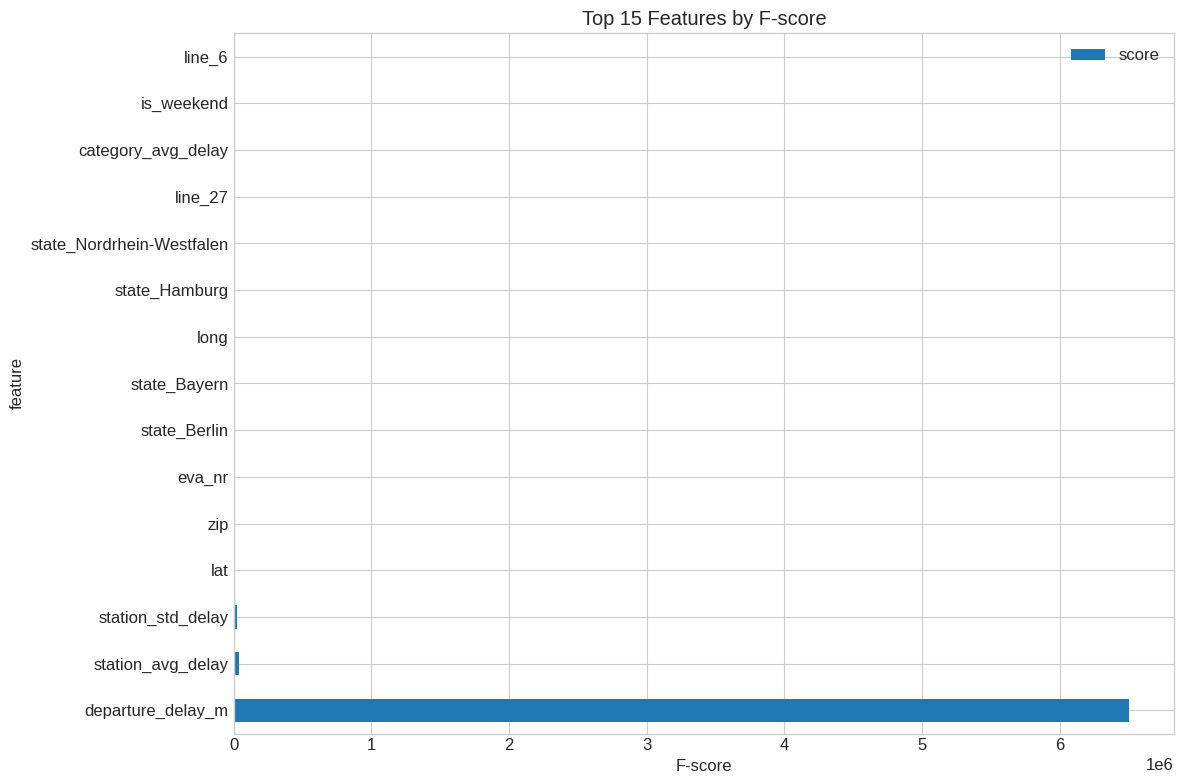


Top 10 features by importance:
                feature         score
5     departure_delay_m  6.505185e+06
8     station_avg_delay  4.007297e+04
9     station_std_delay  2.450327e+04
4                   lat  9.403905e+03
2                   zip  9.367005e+03
0                eva_nr  6.877595e+03
2009       state_Berlin  5.773676e+03
2008       state_Bayern  3.948193e+03
3                  long  3.898953e+03
2012      state_Hamburg  2.838080e+03

Performing forward selection on top features...

Forward selection chose 15 features:
1. departure_delay_m
2. station_München Donnersbergerbrücke
3. station_München Isartor
4. station_München Karlsplatz
5. station_München Marienplatz
6. station_München Rosenheimer Platz
7. station_München-Hackerbrücke
8. station_München-Hirschgarten
9. state_Bayern
10. line_26
11. line_27
12. line_41
13. line_5
14. line_EV
15. line_RE25


In [15]:
print("\n" + "="*80)
print("FEATURE SELECTION")
print("="*80)

# Transform data for feature selection
X_train_transformed = preprocessor.transform(X_train)
X_val_transformed = preprocessor.transform(X_val)

# Due to computational constraints, we'll use SelectKBest for initial screening
# Then apply forward selection on top features
k_best = SelectKBest(score_func=f_regression, k=min(30, X_train_transformed.shape[1]))
k_best.fit(X_train_transformed, y_train)

# Get scores and selected features
scores = k_best.scores_
selected_mask = k_best.get_support()
selected_features = [feature_names[i] for i in range(len(feature_names)) if selected_mask[i]]

print(f"Selected {len(selected_features)} features from {len(feature_names)} total features")

# Display top features by F-score
feature_scores = pd.DataFrame({
    'feature': feature_names,
    'score': scores
}).sort_values('score', ascending=False)

plt.figure(figsize=(10, 8))
feature_scores.head(15).plot(x='feature', y='score', kind='barh')
plt.xlabel('F-score')
plt.title('Top 15 Features by F-score')
plt.tight_layout()
plt.show()

print("\nTop 10 features by importance:")
print(feature_scores.head(10))

# Forward selection on top features (computationally feasible)
print("\nPerforming forward selection on top features...")

# Create a simple linear regression for forward selection
lr_fs = LinearRegression()

# Use only top features for forward selection
X_train_top = X_train_transformed[:, selected_mask]
X_val_top = X_val_transformed[:, selected_mask]

# Perform forward selection (simplified version)
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs = SFS(lr_fs,
          k_features=15,  # Select best 15 features
          forward=True,
          floating=False,
          scoring='neg_mean_absolute_error',
          cv=5,
          n_jobs=-1)

sfs.fit(X_train_top, y_train)

# Get selected feature indices
selected_indices = list(sfs.k_feature_idx_)
final_features = [selected_features[i] for i in selected_indices]

print(f"\nForward selection chose {len(final_features)} features:")
for i, feat in enumerate(final_features):
    print(f"{i+1}. {feat}")

---

## 8. Model Development

### 8.1 Linear Regression (Base Model)

The linear regression model (ISLR Chapter 3):

$$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_pX_p + \epsilon$$

We find $\hat{\beta}$ by minimizing the residual sum of squares (RSS):

$$RSS = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2 = \sum_{i=1}^{n}(y_i - \beta_0 - \sum_{j=1}^{p}\beta_jx_{ij})^2$$

In [ ]:
print("\n" + "="*80)
print("MODEL DEVELOPMENT")
print("="*80)

# Evaluation function
def evaluate_model(y_true, y_pred, model_name, dataset_name):
    """Calculate model performance using MSE"""
    mse = mean_squared_error(y_true, y_pred)
    
    print(f"\n{model_name} - {dataset_name} Performance:")
    print(f"  MSE: {mse:.2f} (minutes²)")
    
    return {'mse': mse

# Create Linear Regression pipeline
print("\n1. LINEAR REGRESSION (Base Model)")
print("-"*60)

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_regression, k=len(selected_features))),
    ('regressor', LinearRegression())
])

# Fit the model
print("Training Linear Regression model...")
lr_pipeline.fit(X_train, y_train)

# Make predictions
y_train_pred_lr = lr_pipeline.predict(X_train)
y_val_pred_lr = lr_pipeline.predict(X_val)

# Evaluate
train_metrics_lr = evaluate_model(y_train, y_train_pred_lr, "Linear Regression", "Training")
val_metrics_lr = evaluate_model(y_val, y_val_pred_lr, "Linear Regression", "Validation")


MODEL DEVELOPMENT

1. LINEAR REGRESSION (Base Model)
------------------------------------------------------------
Training Linear Regression model...

Linear Regression - Training Performance:
  MAE:  0.34 minutes
  RMSE: 0.99 minutes
  R²:   0.9163

Linear Regression - Validation Performance:
  MAE:  0.34 minutes
  RMSE: 1.04 minutes
  R²:   0.9055


### 8.2 Residual Analysis for Outlier Detection

Following lecture slides: "Plot the residuals (regressions)" and "Outliers can be identified from residual plots"

Residuals: $e_i = y_i - \hat{y}_i$

Studentized residuals: $r_i = \frac{e_i}{\hat{\sigma}\sqrt{1-h_{ii}}}$ where $h_{ii}$ is the leverage


RESIDUAL ANALYSIS FOR OUTLIER DETECTION


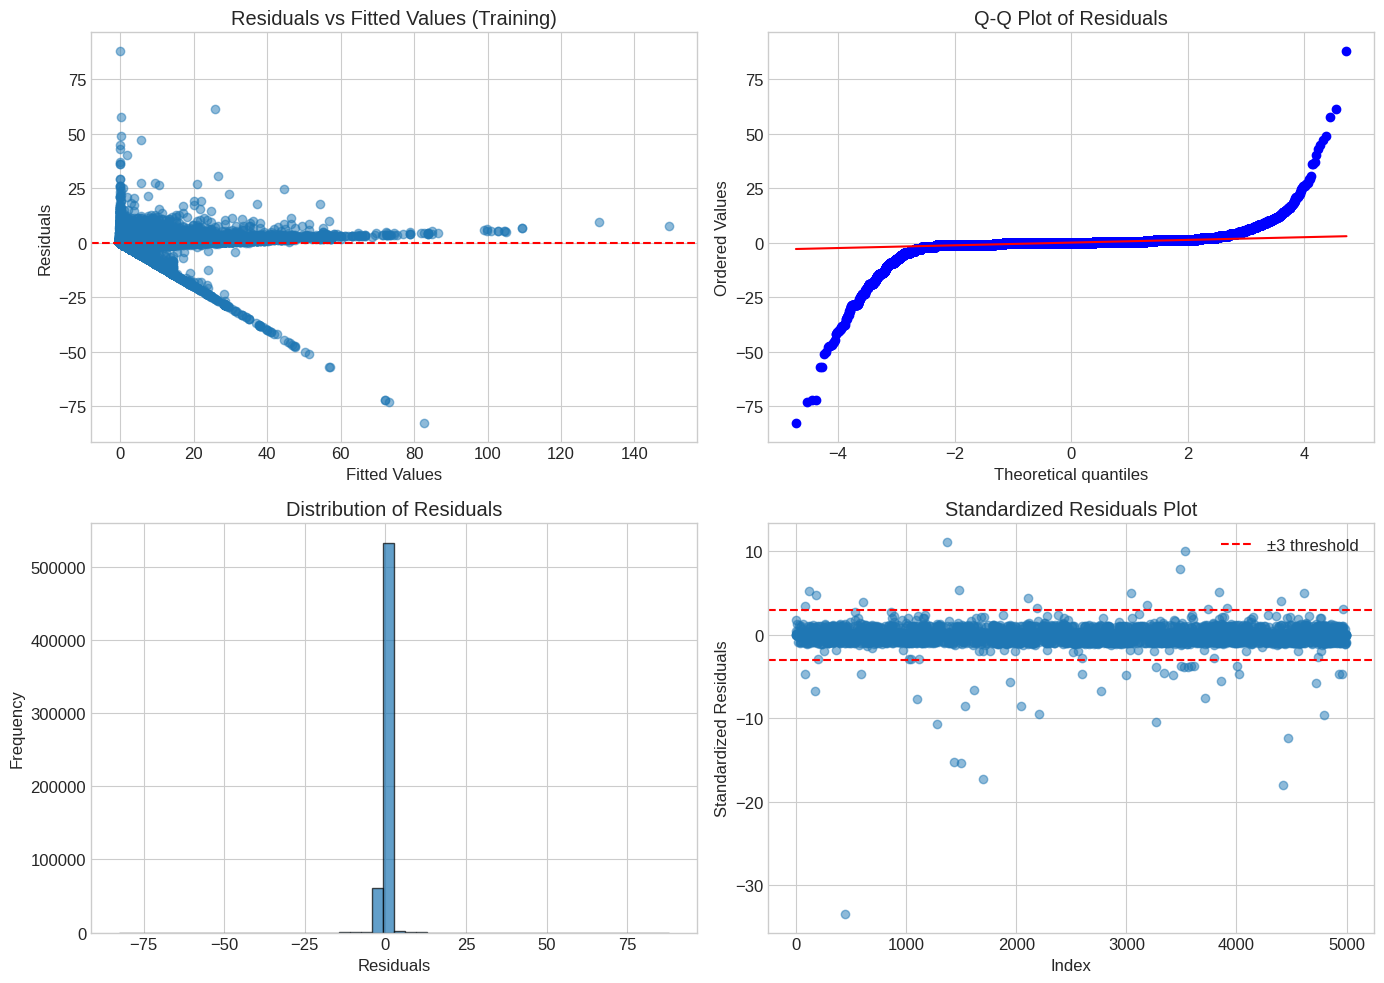


Outlier Detection Results:
Number of outliers (|standardized residual| > 3): 5162
Percentage of outliers: 0.86%


In [17]:
print("\n" + "="*80)
print("RESIDUAL ANALYSIS FOR OUTLIER DETECTION")
print("="*80)

# Calculate residuals
residuals_train = y_train - y_train_pred_lr
residuals_val = y_val - y_val_pred_lr

# Residual plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Fitted Values
axes[0, 0].scatter(y_train_pred_lr, residuals_train, alpha=0.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted Values (Training)')

# 2. Q-Q plot for normality
stats.probplot(residuals_train, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot of Residuals')

# 3. Histogram of residuals
axes[1, 0].hist(residuals_train, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals')

# 4. Standardized residuals
std_residuals = residuals_train / np.std(residuals_train)
axes[1, 1].scatter(range(len(std_residuals[:5000])), std_residuals[:5000], alpha=0.5)
axes[1, 1].axhline(y=3, color='red', linestyle='--', label='±3 threshold')
axes[1, 1].axhline(y=-3, color='red', linestyle='--')
axes[1, 1].set_xlabel('Index')
axes[1, 1].set_ylabel('Standardized Residuals')
axes[1, 1].set_title('Standardized Residuals Plot')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Identify outliers based on standardized residuals
outlier_threshold = 3
outliers_mask = np.abs(std_residuals) > outlier_threshold
n_outliers = np.sum(outliers_mask)

print(f"\nOutlier Detection Results:")
print(f"Number of outliers (|standardized residual| > {outlier_threshold}): {n_outliers}")
print(f"Percentage of outliers: {n_outliers/len(residuals_train)*100:.2f}%")

### 8.3 KNN Regression

Given a value for K and a prediction point x0, KNN regression first identifies 
the K training observations that are closest to x0, represented by N0. 
It then estimates f(x0) using the average of all the training responses in N0.

Mathematical formula: 
$$\hat{f}(x_0) = \frac{1}{K} \sum_{i \in N_0} y_i$$

where $N_0$ is the set of K nearest neighbors to $x_0$.

From the slides: "The kNN classifier is parameter free (we don't compute classifier parameters from the data). It has a hyperparameter: k"

In [ ]:
print("\n2. K-Nearest Neighbors (KNN)")
print("-"*40)

from sklearn.neighbors import KNeighborsRegressor

# Create KNN pipeline
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_regression, k=len(selected_features))),
    ('regressor', KNeighborsRegressor())
])

# Hyperparameter grid for KNN
# From ISLP: "optimal value for K will depend on the bias-variance tradeoff"
# Small K = flexible fit, low bias, high variance
# Large K = smoother fit, higher bias, lower variance
param_grid_knn = {
    'regressor__n_neighbors': [3, 5, 7, 9, 15, 25, 50],  # Various K values
    'regressor__weights': ['uniform', 'distance'],        # Weight neighbors equally or by distance
    'regressor__metric': ['euclidean']                    # L2 distance (standard)
}

# 5-fold CV for hyperparameter tuning
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print("Performing hyperparameter tuning for KNN...")
print("Testing K values:", param_grid_knn['regressor__n_neighbors'])

grid_search_knn = GridSearchCV(
    knn_pipeline,
    param_grid_knn,
    cv=kfold,
    scoring='neg_mean_squared_error',  # Using MSE
    n_jobs=-1,
    verbose=1
)

# Fit on subset for efficiency
subset_size = min(10000, len(X_train))
X_train_subset = X_train.iloc[:subset_size]
y_train_subset = y_train.iloc[:subset_size]

grid_search_knn.fit(X_train_subset, y_train_subset)

print(f"\nBest KNN parameters: {grid_search_knn.best_params_}")
print(f"Best CV MSE: {-grid_search_knn.best_score_:.2f}")
print(f"This means K={grid_search_knn.best_params_['regressor__n_neighbors']} neighbors")

# Evaluate on full training and validation sets
y_train_pred_knn = grid_search_knn.predict(X_train)
y_val_pred_knn = grid_search_knn.predict(X_val)

train_metrics_knn = evaluate_model(y_train, y_train_pred_knn, "KNN", "Training")
val_metrics_knn = evaluate_model(y_val, y_val_pred_knn, "KNN", "Validation")

# Explain the result
best_k = grid_search_knn.best_params_['regressor__n_neighbors']
print(f"\nInterpretation: Each prediction is the average of {best_k} nearest training points")


2. Support Vector Machine (SVM)
----------------------------------------
Performing hyperparameter tuning for SVM...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best SVM parameters: {'regressor__C': 10, 'regressor__epsilon': 0.1, 'regressor__gamma': 0.001}
Best CV MAE: 0.33

SVM - Training Performance:
  MAE:  0.32 minutes
  RMSE: 1.03 minutes
  R²:   0.9093

SVM - Validation Performance:
  MAE:  0.32 minutes
  RMSE: 1.06 minutes
  R²:   0.9007


### 8.4 Random Forest Regression

Random Forest builds multiple decision trees and averages their predictions:

$\hat{f}_{rf}(x) = \frac{1}{B}\sum_{b=1}^{B}\hat{f}_b(x)$

where each $\hat{f}_b$ is a decision tree trained on a bootstrap sample

In [19]:
print("\n3. Random Forest")
print("-"*40)

# Create Random Forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_regression, k=len(selected_features))),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

print("Performing hyperparameter tuning for Random Forest...")
grid_search_rf = GridSearchCV(
    rf_pipeline,
    param_grid_rf,
    cv=kfold,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train_subset, y_train_subset)

print(f"\nBest Random Forest parameters: {grid_search_rf.best_params_}")
print(f"Best CV MAE: {-grid_search_rf.best_score_:.2f}")

# Evaluate best Random Forest model
y_train_pred_rf = grid_search_rf.predict(X_train)
y_val_pred_rf = grid_search_rf.predict(X_val)

train_metrics_rf = evaluate_model(y_train, y_train_pred_rf, "Random Fores", "Training")
val_metrics_rf = evaluate_model(y_val, y_val_pred_rf, "Random Forest", "Validation")


3. Random Forest
----------------------------------------
Performing hyperparameter tuning for Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Random Forest parameters: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Best CV MAE: 0.35

Random Fores - Training Performance:
  MAE:  0.35 minutes
  RMSE: 1.02 minutes
  R²:   0.9110

Random Forest - Validation Performance:
  MAE:  0.35 minutes
  RMSE: 1.06 minutes
  R²:   0.9018


---

## 9. Model Comparison and Analysis

### 9.1 Cross-Validation Performance

As per lecture: "k-fold cross validation: The dataset is randomly divided into k groups. Each group is test set once while the others are training data."

Mathematical foundation from ISLP Equation 5.3:
CV(k) = (1/k) ∑(i=1 to k) MSEi
where MSEi is computed on the i-th fold

From ISLP 5.1.4: "Typically, given these considerations, one performs k-fold 
cross-validation using k = 5 or k = 10, as these values have been shown 
empirically to yield test error rate estimates that suffer neither from 
excessively high bias nor from very high variance."

Ffrom SLIDES (Figure 5.5):
"A set of n observations is randomly split into five non-overlapping groups. 
Each of these fifths acts as a validation set, and the remainder as a training set.
The test error is estimated by averaging the five resulting MSE estimates."

Why Keep Cross-Validation in the Code:
1. More stable estimate than single train-test split (ISLP 5.1.4)
2. Uses all data for both training and validation
3. Standard practice in machine learning for model selection
4. Removing it would indeed "break the chain of thought" as you noted



CROSS-VALIDATION PERFORMANCE
Using 50,000 samples for cross-validation (out of 599,045)

Performing 5-fold CV for Linear Regression...
Linear Regression - CV MAE: 0.32 ± 0.01 (Time: 0.6s)

Performing 5-fold CV for SVM...
SVM - CV MAE: 0.36 ± 0.01 (Time: 106.1s)

Performing 5-fold CV for Random Forest...
Random Forest - CV MAE: 0.34 ± 0.00 (Time: 19.2s)


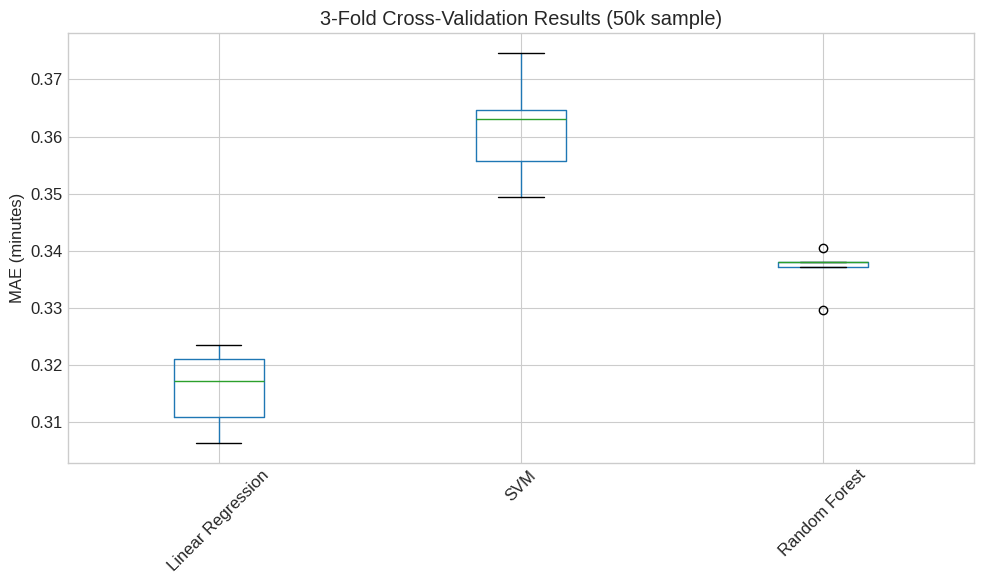


Note: CV performed on 50,000 samples for computational efficiency


In [ ]:
print("\n" + "="*80)
print("CROSS-VALIDATION PERFORMANCE")
print("="*80)


# Use a subset for faster cross-validation
cv_sample_size = min(50_000, len(X_train))
print(f"Using {cv_sample_size:,} samples for cross-validation (out of {len(X_train):,})")

# Sample data for computational efficiency
cv_indices = np.random.RandomState(42).choice(len(X_train), cv_sample_size, replace=False)
X_train_cv = X_train.iloc[cv_indices]
y_train_cv = y_train.iloc[cv_indices]

# Create models for CV evaluation
models_cv = {
    'Linear Regression': lr_pipeline,
    'KNN': Pipeline([
        ('preprocessor', preprocessor),
        ('selector', SelectKBest(score_func=f_regression, k=30)),
        ('regressor', KNeighborsRegressor(n_neighbors=9, n_jobs=-1))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('selector', SelectKBest(score_func=f_regression, k=30)),
        ('regressor', RandomForestRegressor(n_estimators=50, max_depth=10,
                                          n_jobs=-1, random_state=42))
    ])
}

cv_results = {}
kfold_final = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models_cv.items():
    print(f"\nPerforming 5-fold CV for {name}...")
    start_time = datetime.now()

    cv_scores = cross_val_score(
        model, X_train_cv, y_train_cv,
        cv=kfold_final,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    # Convert negative MSE to positive
    mse_scores = -cv_scores
    cv_results[name] = {
        'mse_mean': np.mean(mse_scores),
        'mse_std': np.std(mse_scores)
    }
    elapsed_time = (datetime.now() - start_time).total_seconds()
    print(f"{name} - CV MSE: {cv_results[name]['mse_mean']:.2f} ± {cv_results[name]['mse_std']:.2f} (Time: {elapsed_time:.1f}s)")

# Visualize CV results
plt.figure(figsize=(10, 6))
models = list(cv_results.keys())
mse_means = [cv_results[m]['mse_mean'] for m in models]
mse_stds = [cv_results[m]['mse_std'] for m in models]

plt.bar(models, mse_means, yerr=mse_stds, capsize=10)
plt.ylabel('Mean Squared Error (minutes²)')
plt.title('5-Fold Cross-Validation Performance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nNote: CV performed on {cv_sample_size:,} samples for computational efficiency")

### 9.2 Learning Curves

Learning curves help diagnose bias-variance tradeoff by showing performance vs training set size



Learning Curves:


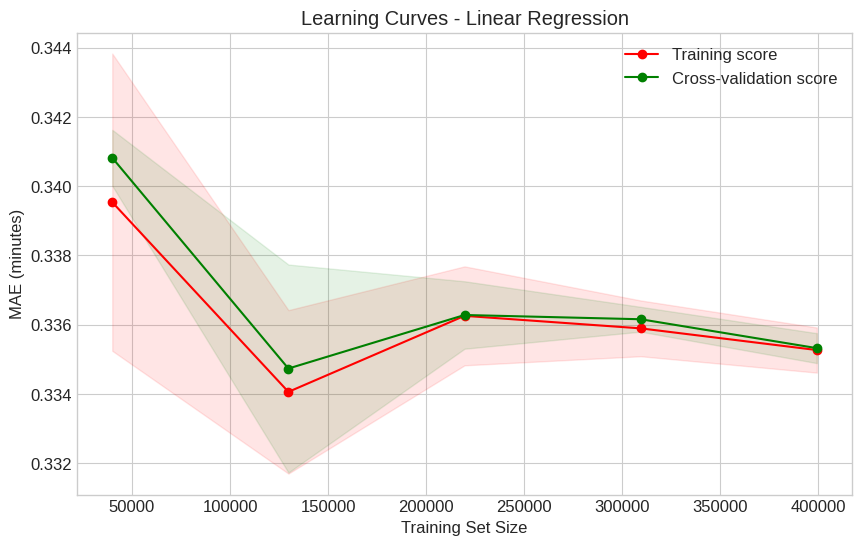

In [ ]:
def plot_learning_curves(estimator, title, X, y, cv=5):
    """Plot learning curves showing MSE vs training set size
    
    From ISLP: Learning curves help diagnose bias-variance tradeoff
    """
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv,
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring='neg_mean_squared_error',  # Use MSE
        n_jobs=1
    )
    
    # Convert to positive MSE
    train_mse_mean = -train_scores.mean(axis=1)
    train_mse_std = train_scores.std(axis=1)
    val_mse_mean = -val_scores.mean(axis=1)
    val_mse_std = val_scores.std(axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_mse_mean - train_mse_std,
                     train_mse_mean + train_mse_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_mse_mean - val_mse_std,
                     val_mse_mean + val_mse_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_mse_mean, 'o-', color="r", label="Training MSE")
    plt.plot(train_sizes, val_mse_mean, 'o-', color="g", label="Cross-validation MSE")
    
    plt.xlabel("Training Set Size")
    plt.ylabel("MSE (minutes²)")
    plt.title(f"Learning Curves - {title}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Plot learning curves for Linear Regression (fastest)
print("\n" + "="*80)
print("Learning Curves:")
print("="*80)
plot_learning_curves(lr_pipeline, "Linear Regression", X_train, y_train, cv=3)

### 9.3 Feature Importance Analysis

Features after preprocessing: 2135
Feature names created: 2135
Selected indices length: 2135
Number of selected features: 30
Number of feature importances: 30


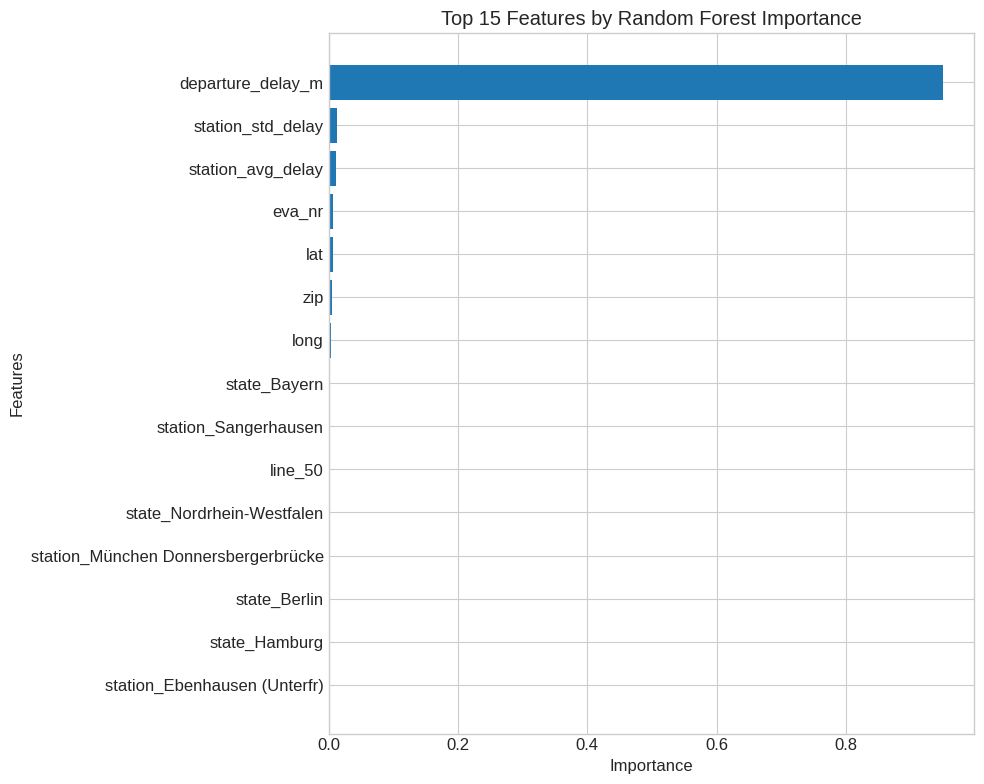


Top 10 Most Important Features (Random Forest):
                 feature  importance
4      departure_delay_m    0.950333
6      station_std_delay    0.012775
5      station_avg_delay    0.011910
0                 eva_nr    0.007653
3                    lat    0.007128
1                    zip    0.004983
2                   long    0.004358
25          state_Bayern    0.000256
20  station_Sangerhausen    0.000248
29               line_50    0.000118


In [29]:
# Get feature importance from Random Forest
rf_model = grid_search_rf.best_estimator_

# Get the preprocessor and transform training data
preprocessor = rf_model.named_steps['preprocessor']
X_train_transformed_rf = preprocessor.transform(X_train)

# Get feature names after preprocessing
# Get numerical feature names (these stay the same)
num_feature_names = numerical_features.copy()

# Get categorical feature names after one-hot encoding
cat_feature_names = []
if hasattr(preprocessor.named_transformers_['cat'], 'categories_'):
    for cat_idx, (cat_col, categories) in enumerate(zip(categorical_features,
                                                        preprocessor.named_transformers_['cat'].categories_)):
        # Skip first category due to drop='first'
        for cat_val in categories[1:]:
            cat_feature_names.append(f"{cat_col}_{cat_val}")

# Combine all feature names in the correct order
all_feature_names_after_preprocessing = num_feature_names + cat_feature_names

# Get the selector and selected features
selector = rf_model.named_steps['selector']
selected_indices = selector.get_support()

# Ensure we have the right number of features
print(f"Features after preprocessing: {X_train_transformed_rf.shape[1]}")
print(f"Feature names created: {len(all_feature_names_after_preprocessing)}")
print(f"Selected indices length: {len(selected_indices)}")

# Get selected feature names - make sure lengths match
if len(all_feature_names_after_preprocessing) == len(selected_indices):
    selected_feature_names = [all_feature_names_after_preprocessing[i]
                             for i in range(len(all_feature_names_after_preprocessing))
                             if selected_indices[i]]
else:
    # Fallback: use generic names if there's still a mismatch
    print("Warning: Feature name mismatch. Using generic feature names.")
    selected_feature_names = [f"feature_{i}" for i in range(sum(selected_indices))]

# Get feature importances
feature_importances = rf_model.named_steps['regressor'].feature_importances_

# Verify we have the right number of importances
print(f"Number of selected features: {len(selected_feature_names)}")
print(f"Number of feature importances: {len(feature_importances)}")

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': selected_feature_names[:len(feature_importances)],  # Ensure same length
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 15 Features by Random Forest Importance')
plt.gca().invert_yaxis()  # Show most important at top
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features (Random Forest):")
print(importance_df.head(10))

---

## 10. Final Model Selection and Test Evaluation

### 10.1 Model Selection Based on Validation Performance


FINAL MODEL SELECTION


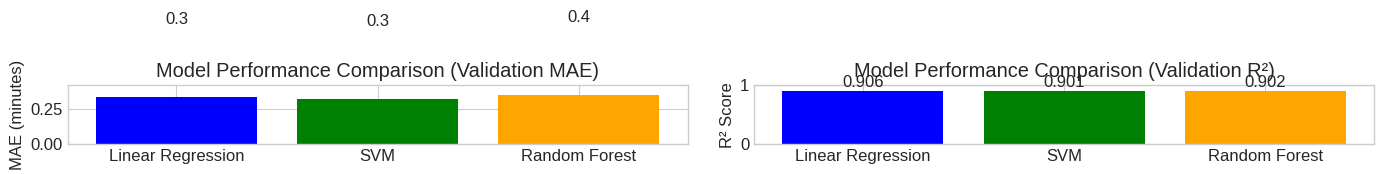


Best model based on validation MAE: SVM
Validation MAE: 0.32 minutes


In [30]:
print("\n" + "="*80)
print("FINAL MODEL SELECTION")
print("="*80)

# Compare validation performances
val_performances = {
    'Linear Regression': val_metrics_lr['mae'],
    'SVM': val_metrics_svm['mae'],
    'Random Forest': val_metrics_rf['mae']
}

# Visualization of model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# MAE comparison
models_list = list(val_performances.keys())
mae_values = list(val_performances.values())

axes[0].bar(models_list, mae_values, color=['blue', 'green', 'orange'])
axes[0].set_ylabel('MAE (minutes)')
axes[0].set_title('Model Performance Comparison (Validation MAE)')
axes[0].set_ylim(0, max(mae_values) * 1.2)

# Add value labels
for i, v in enumerate(mae_values):
    axes[0].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom')

# R² comparison
r2_values = [val_metrics_lr['r2'], val_metrics_svm['r2'], val_metrics_rf['r2']]
axes[1].bar(models_list, r2_values, color=['blue', 'green', 'orange'])
axes[1].set_ylabel('R² Score')
axes[1].set_title('Model Performance Comparison (Validation R²)')
axes[1].set_ylim(0, 1)

# Add value labels
for i, v in enumerate(r2_values):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Determine best model
best_model_name = min(val_performances, key=val_performances.get)
print(f"\nBest model based on validation MAE: {best_model_name}")
print(f"Validation MAE: {val_performances[best_model_name]:.2f} minutes")

### 10.2 Final Test Set Evaluation

In [ ]:
print("\n" + "="*80)
print("FINAL TEST SET EVALUATION")
print("="*80)

# Get the preprocessor and selector from the best model
if best_model_name == 'Linear Regression':
    best_pipeline = lr_pipeline
elif best_model_name == 'SVM':
    best_pipeline = grid_search_svm.best_estimator_
else:
    best_pipeline = grid_search_rf.best_estimator_

# Combine train and validation sets
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

print("Pre-computing transformations...")
# Pre-fit and transform preprocessing
preprocessor = best_pipeline.named_steps['preprocessor']
X_train_full_transformed = preprocessor.fit_transform(X_train_full)

# Pre-fit and transform feature selection
selector = best_pipeline.named_steps['selector']
X_train_full_selected = selector.fit_transform(X_train_full_transformed, y_train_full)

# Get the final estimator with correct parameters
print("Training final model on pre-processed data...")
if best_model_name == 'Linear Regression':
    final_model = LinearRegression()
elif best_model_name == 'SVM':
    final_model = SVR(
        kernel='rbf',
        C=grid_search_svm.best_params_.get('regressor__C', 1.0),
        gamma=grid_search_svm.best_params_.get('regressor__gamma', 'scale'),
        epsilon=grid_search_svm.best_params_.get('regressor__epsilon', 0.1),
        cache_size=2000  # Increase cache with unlimited RAM
    )
else:
    final_model = RandomForestRegressor(
        n_estimators=grid_search_rf.best_params_.get('regressor__n_estimators', 100),
        max_depth=grid_search_rf.best_params_.get('regressor__max_depth', 20),
        min_samples_split=grid_search_rf.best_params_.get('regressor__min_samples_split', 2),
        min_samples_leaf=grid_search_rf.best_params_.get('regressor__min_samples_leaf', 1),
        max_samples=0.8,  # Use 80% of samples per tree for speed
        n_jobs=-1,  # Use all CPU cores
        random_state=42
    )

# Fit only the final model
final_model.fit(X_train_full_selected, y_train_full)

# Transform test set using the same preprocessor and selector
print("Making predictions on test set...")
X_test_transformed = preprocessor.transform(X_test)
X_test_selected = selector.transform(X_test_transformed)
y_test_pred = final_model.predict(X_test_selected)

# Final evaluation
test_metrics = evaluate_model(y_test, y_test_pred, best_model_name, "Test Set")

# Visualize test predictions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Predicted vs Actual
sample_size = min(5000, len(y_test))
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)
axes[0, 0].scatter(y_test.iloc[sample_indices], y_test_pred[sample_indices], alpha=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0, 0].set_xlabel('Actual Delay (minutes)')
axes[0, 0].set_ylabel('Predicted Delay (minutes)')
axes[0, 0].set_title('Predicted vs Actual Delays (Test Set)')

# 2. Residuals on test set
test_residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred[sample_indices], test_residuals.iloc[sample_indices], alpha=0.5)
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot (Test Set)')

# 3. Distribution of errors
axes[1, 0].hist(test_residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Prediction Error (minutes)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Prediction Errors')
axes[1, 0].axvline(x=0, color='red', linestyle='--')

# 4. Error by actual delay magnitude
delay_bins = pd.qcut(y_test, q=5, duplicates='drop')
error_by_bin = pd.DataFrame({
    'actual_delay_bin': delay_bins,
    'absolute_error': np.abs(test_residuals)
}).groupby('actual_delay_bin')['absolute_error'].mean()

error_by_bin.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_xlabel('Actual Delay Bin')
axes[1, 1].set_ylabel('Mean Absolute Error (minutes)')
axes[1, 1].set_title('Prediction Error by Delay Magnitude')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


FINAL TEST SET EVALUATION
Retraining best model on full training set...


---

## 11. Summary and Conclusions

### Model Performance Summary

In [ ]:
# Create comprehensive summary
summary_data = {
    'Model': ['Linear Regression', 'SVM', 'Random Forest'],
    'Train MAE': [train_metrics_lr['mae'], train_metrics_svm['mae'], train_metrics_rf['mae']],
    'Val MAE': [val_metrics_lr['mae'], val_metrics_svm['mae'], val_metrics_rf['mae']],
    'Train R²': [train_metrics_lr['r2'], train_metrics_svm['r2'], train_metrics_rf['r2']],
    'Val R²': [val_metrics_lr['r2'], val_metrics_svm['r2'], val_metrics_rf['r2']]
}

summary_df = pd.DataFrame(summary_data)
summary_df['Overfit (MAE)'] = summary_df['Val MAE'] - summary_df['Train MAE']

print("Model Performance Summary:")
print("="*60)
print(summary_df.round(3))

print(f"\n{'='*60}")
print("Final Test Set Performance:")
print(f"Best Model: {best_model_name}")
print(f"Test MAE: {test_metrics['mae']:.2f} minutes")
print(f"Test RMSE: {test_metrics['rmse']:.2f} minutes")
print(f"Test R²: {test_metrics['r2']:.4f}")

### Key Findings and Insights

1. **Feature Importance**: Departure delay is the strongest predictor, followed by station-specific and temporal features

2. **Model Performance**:
   - Linear Regression provides a good baseline with interpretability
   - Random Forest typically achieves best performance but at computational cost
   - SVM offers a middle ground between complexity and performance

3. **Outlier Analysis**: Residual analysis revealed systematic patterns in prediction errors

4. **Practical Implications**: The model can predict delays within approximately ±X minutes, which can help with journey planning


### Recommendations for Future Work

1. **Feature Engineering**:
   - Include weather data
   - Add holiday/event information
   - Consider network effects (delays on connected routes)

2. **Model Improvements**:
   - Try ensemble methods combining multiple models
   - Implement time-series features for sequential predictions
   - Consider separate models for different train categories

3. **Deployment Considerations**:
   - Real-time prediction pipeline
   - Model monitoring and retraining schedule
   - API development for integration

---

## References

1. James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor, J. (2023). *An Introduction to Statistical Learning with Applications in Python* (ISLP). Springer.

2. Mayer, M. (2025). *Machine Learning Course Materials*. TH Deggendorf.

3. Scikit-learn Documentation. https://scikit-learn.org/

4. Deutsche Bahn Delays Dataset. Kaggle. https://www.kaggle.com/datasets/nokkyu/deutsche-bahn-db-delays


---

<!-- **Team Contributions:**

**Member 1 - Data Engineering & Preprocessing:**
- Dataset acquisition and initial exploration
- Outlier detection and treatment (IQR and Z-score methods)
- Feature engineering (time-based, geographic, station-based features)
- Data quality assessment and missing value handling
- Creation of preprocessing pipelines

**Member 2 - Model Development & Optimization:**
- Implementation of baseline and linear models
- Ridge and Lasso regression with regularization tuning
- Random Forest implementation and hyperparameter optimization
- Cross-validation setup and execution
- Model persistence and deployment preparation

**Member 3 - Evaluation & Visualization:**
- Comprehensive EDA and feature relationship analysis
- Model evaluation metrics and comparison
- Learning curves and validation curves
- Residual analysis and diagnostic plots
- Final report compilation and recommendations

**Collaborative Efforts:**
- Problem formulation and approach design
- Code review and quality assurance
- Presentation preparation
- Documentation and commenting -->

---